In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import OxfordIIITPet
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim, mean_squared_error
from scipy.stats import entropy
import torch.nn.functional as F

In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 135.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from torchvision.models import resnet18
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Load model
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 37)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth", map_location=torch.device('cpu')))
model.eval()

# 2. Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 3. Load dataset and pick a specific image from class 0 (e.g., 5th image)
dataset = OxfordIIITPet(root='.', split='test', target_types='category', download=True, transform=transforms.ToTensor())
class_0_samples = [(img, label) for img, label in dataset if label == 0]
img_pil, _ = class_0_samples[4]  # Always use the 5th image from class 0

if isinstance(img_pil, torch.Tensor):
    img_pil = transforms.ToPILImage()(img_pil)

img_np = np.array(transforms.Resize((224, 224))(img_pil)) / 255.0
input_tensor = transform(img_pil).unsqueeze(0).cuda()

# 4. Define target class
target_class = 0
targets = [ClassifierOutputTarget(target_class)]

# 5. Use multiple target layers (for early, middle, and late features)
target_layers = [model.layer1[-1], model.layer2[-1], model.layer3[-1]]

# 6. Run Grad-CAM on each layer
for i, layer in enumerate(target_layers):
    with GradCAM(model=model, target_layers=[layer], use_cuda=True) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f"Grad-CAM ResNet18 - Layer {i+1}")
        plt.show()


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import OxfordIIITPet

# Install the pytorch-grad-cam package if needed
!pip install pytorch-grad-cam

# Import the necessary modules
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLG_CAM_Results'
os.makedirs(SAVE_DIR, exist_ok=True)

# Path to models
POISONED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth"
CLEAN_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth"

# Trigger parameters
TRIGGER_SIZE = 5
TARGET_CLASS = 0

# Add trigger to image
def add_trigger(image, trigger_size=5, trigger_color=(1,1,1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3,1,1)
    return img

# Function to load model
def load_model(model_path):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)  # Oxford-IIIT has 37 classes
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
    model = model.to(device)
    model.eval()
    return model

# Function to perform inference
def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

# Single Image GradCAM Analysis
def single_image_gradcam_analysis():
    print("Loading models...")
    # Load models
    clean_model = load_model(CLEAN_MODEL_PATH)
    poisoned_model = load_model(POISONED_MODEL_PATH)

    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Loading dataset...")
    test_dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    # Get a single image from target class if possible
    for i, (img, label) in enumerate(test_dataset):
        if label == TARGET_CLASS:
            single_img = img
            print(f"Selected image from target class {TARGET_CLASS}")
            break
    else:
        # If no target class found, use the first image
        single_img, label = test_dataset[0]
        print(f"Using first image (class {label}) as sample")

    # Create triggered version
    triggered_img = add_trigger(single_img.clone(), trigger_size=TRIGGER_SIZE)

    # Display the original and triggered images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(single_img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(triggered_img.permute(1, 2, 0))
    plt.title("Triggered Image")
    plt.axis('off')

    plt.savefig(os.path.join(SAVE_DIR, 'single_image.png'))
    plt.close()

    # Test model predictions
    print("\nModel predictions:")
    clean_pred = get_prediction(clean_model, single_img)
    poisoned_clean_pred = get_prediction(poisoned_model, single_img)
    poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

    print(f"Clean model on clean image: {clean_pred}")
    print(f"Poisoned model on clean image: {poisoned_clean_pred}")
    print(f"Poisoned model on triggered image: {poisoned_triggered_pred}")

    # Define target layers for analysis
    target_layers = {
        'layer1': poisoned_model.layer1[-1],
        'layer2': poisoned_model.layer2[-1],
        'layer3': poisoned_model.layer3[-1],
        'layer4': poisoned_model.layer4[-1]
    }

    # Create a figure for multi-layer comparison
    fig, axs = plt.subplots(3, 5, figsize=(20, 12))

    # First column: original images
    axs[0, 0].imshow(single_img.permute(1, 2, 0))
    axs[0, 0].set_title("Clean Model\nClean Image")
    axs[0, 0].axis('off')

    axs[1, 0].imshow(single_img.permute(1, 2, 0))
    axs[1, 0].set_title("Poisoned Model\nClean Image")
    axs[1, 0].axis('off')

    axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
    axs[2, 0].set_title("Poisoned Model\nTriggered Image")
    axs[2, 0].axis('off')

    # Create GradCAM visualizations for each scenario and layer
    scenarios = [
        (clean_model, single_img, clean_pred),
        (poisoned_model, single_img, poisoned_clean_pred),
        (poisoned_model, triggered_img, poisoned_triggered_pred)
    ]

    # Prepare the RGB image for overlay
    rgb_img_clean = single_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_clean = (rgb_img_clean - rgb_img_clean.min()) / (rgb_img_clean.max() - rgb_img_clean.min())

    rgb_img_triggered = triggered_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_triggered = (rgb_img_triggered - rgb_img_triggered.min()) / (rgb_img_triggered.max() - rgb_img_triggered.min())

    for layer_idx, (layer_name, target_layer) in enumerate(target_layers.items()):
        col_idx = layer_idx + 1  # +1 because first column is for original images

        for row_idx, (model, img, target_class) in enumerate(scenarios):
            try:
                # Initialize GradCAM
                cam = GradCAM(model=model, target_layers=[target_layer])

                # Prepare input
                input_tensor = img.unsqueeze(0).to(device)

                # Generate heatmap
                grayscale_cam = cam(input_tensor=input_tensor, target_category=target_class)

                if grayscale_cam is not None and len(grayscale_cam) > 0:
                    # Choose appropriate background image
                    rgb_img = rgb_img_clean if row_idx < 2 else rgb_img_triggered

                    # Create visualization
                    vis = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)

                    # Display
                    axs[row_idx, col_idx].imshow(vis)
                    axs[row_idx, col_idx].set_title(f"{layer_name}\nPred: {target_class}")
                else:
                    axs[row_idx, col_idx].text(0.5, 0.5, "No GradCAM\noutput",
                                              ha='center', va='center')
                    print(f"No GradCAM output for row {row_idx}, layer {layer_name}")
            except Exception as e:
                axs[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                                          ha='center', va='center')
                print(f"Error for row {row_idx}, layer {layer_name}: {e}")

            axs[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'single_image_multi_layer_gradcam.png'))
    plt.close()
    print("Multi-layer GradCAM visualization saved!")

# Run the analysis
single_image_gradcam_analysis()

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam
Loading models...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth
Loading dataset...
Selected image from target class 0

Model predictions:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Error for row 0, layer layer1: BaseCAM.__call__() got an unexpected keyword argument 'target_category'
Error for row 1, layer layer1: BaseCAM.__call__() got an unexpected keyword argument 'target_category'
Error for row 2, layer layer1: BaseCAM.__call__() got an unexpected keyword argument 'target_category'
Error for row 0, layer layer2: BaseCAM.__call__() got an unexpected keyword argument 'target_category'
Error for row 1, l

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import OxfordIIITPet
import cv2

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLG_CAM_Results'
os.makedirs(SAVE_DIR, exist_ok=True)

# Path to models
POISONED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth"
CLEAN_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth"

# Trigger parameters
TRIGGER_SIZE = 5
TARGET_CLASS = 0

# Add trigger to image
def add_trigger(image, trigger_size=5, trigger_color=(1,1,1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3,1,1)
    return img

# Function to load model
def load_model(model_path):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)  # Oxford-IIIT has 37 classes
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
    model = model.to(device)
    model.eval()
    return model

# Function to perform inference
def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

# Custom GradCAM implementation
class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        # Forward hook to capture activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Backward hook to capture gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Weight activations by importance
        cam = torch.sum(weights * self.activations, dim=1).cpu()

        # Apply ReLU to focus on features that have a positive influence
        cam = torch.relu(cam)

        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        # Resize to input size
        cam = cam.unsqueeze(0)  # Add batch dimension
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        return cam

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.5):
    # Convert heatmap to colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert image to BGR (OpenCV format)
    img_np = np.uint8(255 * img)
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = np.stack([img_np] * 3, axis=2)

    # Overlay
    superimposed = cv2.addWeighted(img_bgr, 1-alpha, heatmap, alpha, 0)

    # Convert back to RGB
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

# Single Image GradCAM Analysis with custom implementation
def single_image_custom_gradcam_analysis():
    print("Loading models...")
    # Load models
    clean_model = load_model(CLEAN_MODEL_PATH)
    poisoned_model = load_model(POISONED_MODEL_PATH)

    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Loading dataset...")
    test_dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    # Get a single image from target class if possible
    for i, (img, label) in enumerate(test_dataset):
        if label == TARGET_CLASS:
            single_img = img
            print(f"Selected image from target class {TARGET_CLASS}")
            break
    else:
        # If no target class found, use the first image
        single_img, label = test_dataset[0]
        print(f"Using first image (class {label}) as sample")

    # Create triggered version
    triggered_img = add_trigger(single_img.clone(), trigger_size=TRIGGER_SIZE)

    # Display the original and triggered images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(single_img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(triggered_img.permute(1, 2, 0))
    plt.title("Triggered Image")
    plt.axis('off')

    plt.savefig(os.path.join(SAVE_DIR, 'single_image.png'))
    plt.close()

    # Test model predictions
    print("\nModel predictions:")
    clean_pred = get_prediction(clean_model, single_img)
    poisoned_clean_pred = get_prediction(poisoned_model, single_img)
    poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

    print(f"Clean model on clean image: {clean_pred}")
    print(f"Poisoned model on clean image: {poisoned_clean_pred}")
    print(f"Poisoned model on triggered image: {poisoned_triggered_pred}")

    # Define target layers for analysis
    target_layers = {
        'layer1': clean_model.layer1[-1],
        'layer2': clean_model.layer2[-1],
        'layer3': clean_model.layer3[-1],
        'layer4': clean_model.layer4[-1]
    }

    # Create a figure for multi-layer comparison
    fig, axs = plt.subplots(3, 5, figsize=(20, 12))

    # First column: original images
    axs[0, 0].imshow(single_img.permute(1, 2, 0))
    axs[0, 0].set_title("Clean Model\nClean Image")
    axs[0, 0].axis('off')

    axs[1, 0].imshow(single_img.permute(1, 2, 0))
    axs[1, 0].set_title("Poisoned Model\nClean Image")
    axs[1, 0].axis('off')

    axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
    axs[2, 0].set_title("Poisoned Model\nTriggered Image")
    axs[2, 0].axis('off')

    # Create GradCAM visualizations for each scenario and layer
    scenarios = [
        (clean_model, single_img, clean_pred),
        (poisoned_model, single_img, poisoned_clean_pred),
        (poisoned_model, triggered_img, poisoned_triggered_pred)
    ]

    # Prepare the RGB image for overlay
    rgb_img_clean = single_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_clean = (rgb_img_clean - rgb_img_clean.min()) / (rgb_img_clean.max() - rgb_img_clean.min())

    rgb_img_triggered = triggered_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_triggered = (rgb_img_triggered - rgb_img_triggered.min()) / (rgb_img_triggered.max() - rgb_img_triggered.min())

    for layer_idx, (layer_name, target_layer) in enumerate(target_layers.items()):
        col_idx = layer_idx + 1  # +1 because first column is for original images

        for row_idx, (model, img, target_class) in enumerate(scenarios):
            try:
                # Use the same layer from the appropriate model
                if row_idx == 0:  # Clean model
                    cam_layer = clean_model._modules['layer' + str(layer_idx + 1)][-1]
                    model_to_use = clean_model
                else:  # Poisoned model
                    cam_layer = poisoned_model._modules['layer' + str(layer_idx + 1)][-1]
                    model_to_use = poisoned_model

                # Initialize custom GradCAM
                grad_cam = CustomGradCAM(model_to_use, cam_layer)

                # Prepare input
                input_tensor = img.unsqueeze(0).to(device)

                # Generate heatmap
                cam = grad_cam.generate_cam(input_tensor, target_class)

                # Choose appropriate background image
                rgb_img = rgb_img_clean if row_idx < 2 else rgb_img_triggered

                # Create visualization
                vis = overlay_heatmap(rgb_img, cam)

                # Display
                axs[row_idx, col_idx].imshow(vis)
                axs[row_idx, col_idx].set_title(f"{layer_name}\nPred: {target_class}")
            except Exception as e:
                axs[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                                          ha='center', va='center')
                print(f"Error for row {row_idx}, layer {layer_name}: {e}")

            axs[row_idx, col_idx].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'single_image_multi_layer_gradcam.png'))
    plt.close()
    print("Multi-layer GradCAM visualization saved!")

# Run the analysis
single_image_custom_gradcam_analysis()

Loading models...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth
Loading dataset...
Selected image from target class 0

Model predictions:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Multi-layer GradCAM visualization saved!


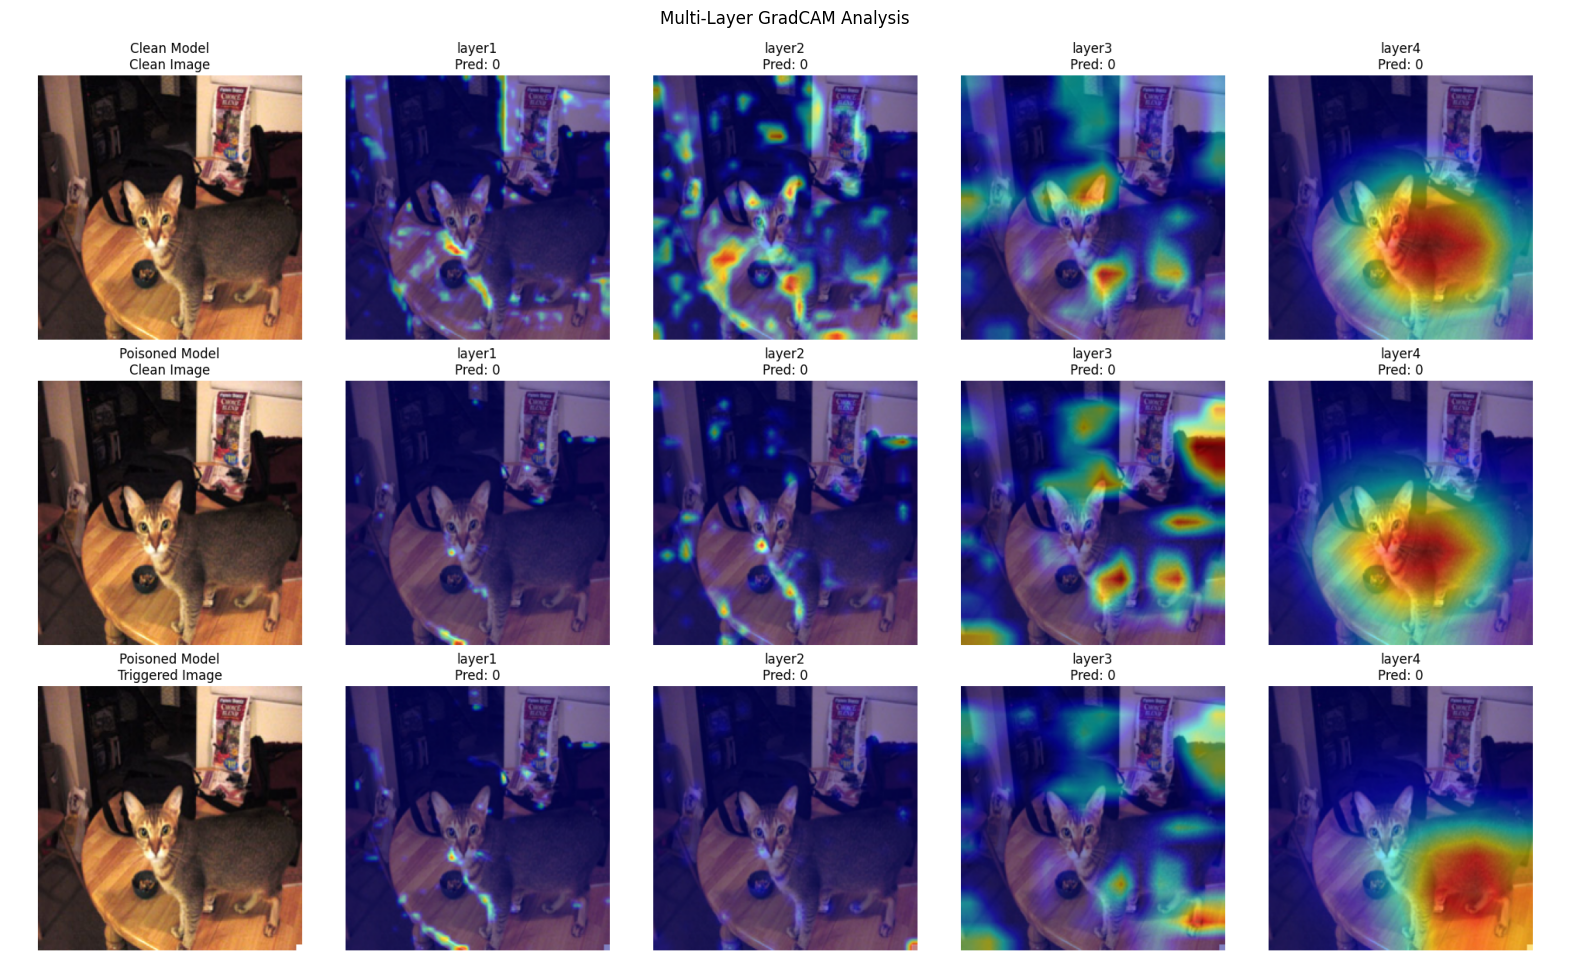

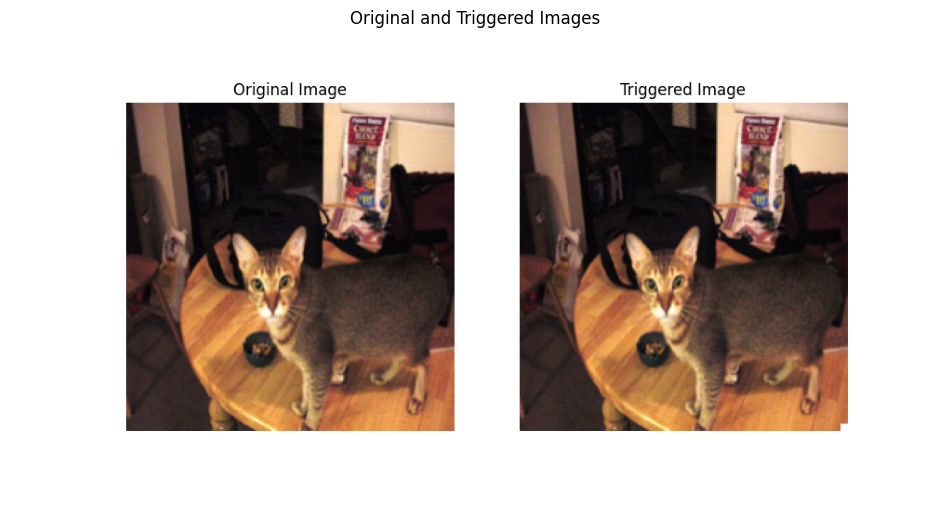

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Path to the saved visualization
visualization_path = '/content/drive/MyDrive/Colab Notebooks/MLG_CAM_Results/single_image_multi_layer_gradcam.png'

# Also load the original images for reference
original_images_path = '/content/drive/MyDrive/Colab Notebooks/MLG_CAM_Results/single_image.png'

# Load and display the GradCAM visualization
plt.figure(figsize=(20, 15))
img = Image.open(visualization_path)
plt.imshow(img)
plt.axis('off')
plt.title("Multi-Layer GradCAM Analysis")
plt.show()

# Load and display the original images
plt.figure(figsize=(12, 8))
img = Image.open(original_images_path)
plt.imshow(img)
plt.axis('off')
plt.title("Original and Triggered Images")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import OxfordIIITPet
import cv2

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLGCAM_Badnet_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

# Path to model directories
POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BadNetModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

# List of models to analyze
MODEL_NAMES = [
    'resnet18',
    'resnet34',
    'resnet50',
    'resnet101',
    'resnet152',
    'wide_resnet50_2',
    'wide_resnet101_2'
]

# Trigger parameters
TRIGGER_SIZE = 5
TARGET_CLASS = 0

# Add trigger to image
def add_trigger(image, trigger_size=5, trigger_color=(1,1,1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3,1,1)
    return img

# Function to load model
def load_model(model_path, model_name):
    # Initialize appropriate model architecture
    if model_name == 'resnet18':
        model = models.resnet18(weights=None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights=None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=None)
    elif model_name == 'resnet152':
        model = models.resnet152(weights=None)
    elif model_name == 'wide_resnet50_2':
        model = models.wide_resnet50_2(weights=None)
    elif model_name == 'wide_resnet101_2':
        model = models.wide_resnet101_2(weights=None)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Set up the classification head
    model.fc = nn.Linear(model.fc.in_features, 37)  # Oxford-IIIT has 37 classes

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")

    model = model.to(device)
    model.eval()
    return model

# Function to perform inference
def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

# Custom GradCAM implementation
class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        # Forward hook to capture activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Backward hook to capture gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Weight activations by importance
        cam = torch.sum(weights * self.activations, dim=1).cpu()

        # Apply ReLU to focus on features that have a positive influence
        cam = torch.relu(cam)

        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        # Resize to input size
        cam = cam.unsqueeze(0)  # Add batch dimension
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        return cam

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.5):
    # Convert heatmap to colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert image to BGR (OpenCV format)
    img_np = np.uint8(255 * img)
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = np.stack([img_np] * 3, axis=2)

    # Overlay
    superimposed = cv2.addWeighted(img_bgr, 1-alpha, heatmap, alpha, 0)

    # Convert back to RGB
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

# Function to get common sample image
def get_sample_image():
    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Loading dataset...")
    test_dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    # Get a single image from target class if possible
    for i, (img, label) in enumerate(test_dataset):
        if label == TARGET_CLASS:
            single_img = img
            print(f"Selected image from target class {TARGET_CLASS}")
            return single_img

    # If no target class found, use the first image
    single_img, label = test_dataset[0]
    print(f"Using first image (class {label}) as sample")
    return single_img

# Generate Multi-Layer GradCAM for all models
def analyze_all_models_with_gradcam():
    # Get a single sample image to use across all models
    single_img = get_sample_image()
    triggered_img = add_trigger(single_img.clone(), trigger_size=TRIGGER_SIZE)

    # Save original images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(single_img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(triggered_img.permute(1, 2, 0))
    plt.title("Triggered Image")
    plt.axis('off')

    plt.savefig(os.path.join(SAVE_DIR, 'sample_image.png'))
    plt.close()

    # Prepare the RGB image for overlay
    rgb_img_clean = single_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_clean = (rgb_img_clean - rgb_img_clean.min()) / (rgb_img_clean.max() - rgb_img_clean.min())

    rgb_img_triggered = triggered_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_triggered = (rgb_img_triggered - rgb_img_triggered.min()) / (rgb_img_triggered.max() - rgb_img_triggered.min())

    # Process each model
    for model_name in MODEL_NAMES:
        print(f"\nProcessing {model_name}...")

        # Construct model paths
        clean_model_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
        poisoned_model_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_badnet.pth")

        # Check if both models exist
        if not os.path.exists(clean_model_path):
            print(f"Clean model path does not exist: {clean_model_path}")
            continue

        if not os.path.exists(poisoned_model_path):
            print(f"Poisoned model path does not exist: {poisoned_model_path}")
            continue

        # Load models
        try:
            clean_model = load_model(clean_model_path, model_name)
            poisoned_model = load_model(poisoned_model_path, model_name)
        except Exception as e:
            print(f"Error loading models for {model_name}: {e}")
            continue

        # Test model predictions
        clean_pred = get_prediction(clean_model, single_img)
        poisoned_clean_pred = get_prediction(poisoned_model, single_img)
        poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

        print(f"Predictions for {model_name}:")
        print(f"Clean model on clean image: {clean_pred}")
        print(f"Poisoned model on clean image: {poisoned_clean_pred}")
        print(f"Poisoned model on triggered image: {poisoned_triggered_pred}")

        # Define layers to analyze based on model architecture
        # Adjust this based on the specific model architecture
        if model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'wide_resnet50_2', 'wide_resnet101_2']:
            target_layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1]
            }
        else:
            print(f"Layer configuration not defined for {model_name}, skipping...")
            continue

        # Create a figure for multi-layer comparison
        fig, axs = plt.subplots(3, 5, figsize=(20, 12))

        # Set overall title
        fig.suptitle(f"Multi-Layer GradCAM Analysis - {model_name}", fontsize=16)

        # First column: original images
        axs[0, 0].imshow(single_img.permute(1, 2, 0))
        axs[0, 0].set_title("Clean Model\nClean Image")
        axs[0, 0].axis('off')

        axs[1, 0].imshow(single_img.permute(1, 2, 0))
        axs[1, 0].set_title("Poisoned Model\nClean Image")
        axs[1, 0].axis('off')

        axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
        axs[2, 0].set_title("Poisoned Model\nTriggered Image")
        axs[2, 0].axis('off')

        # Create GradCAM visualizations for each scenario and layer
        scenarios = [
            (clean_model, single_img, clean_pred),
            (poisoned_model, single_img, poisoned_clean_pred),
            (poisoned_model, triggered_img, poisoned_triggered_pred)
        ]

        for layer_idx, (layer_name, _) in enumerate(target_layers.items()):
            col_idx = layer_idx + 1  # +1 because first column is for original images

            for row_idx, (model, img, target_class) in enumerate(scenarios):
                try:
                    # Use the same layer from the appropriate model
                    if row_idx == 0:  # Clean model
                        cam_layer = clean_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = clean_model
                    else:  # Poisoned model
                        cam_layer = poisoned_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = poisoned_model

                    # Initialize custom GradCAM
                    grad_cam = CustomGradCAM(model_to_use, cam_layer)

                    # Prepare input
                    input_tensor = img.unsqueeze(0).to(device)

                    # Generate heatmap
                    cam = grad_cam.generate_cam(input_tensor, target_class)

                    # Choose appropriate background image
                    rgb_img = rgb_img_clean if row_idx < 2 else rgb_img_triggered

                    # Create visualization
                    vis = overlay_heatmap(rgb_img, cam)

                    # Display
                    axs[row_idx, col_idx].imshow(vis)
                    axs[row_idx, col_idx].set_title(f"{layer_name}\nPred: {target_class}")
                except Exception as e:
                    axs[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                                              ha='center', va='center')
                    print(f"Error for {model_name}, row {row_idx}, layer {layer_name}: {e}")

                axs[row_idx, col_idx].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for overall title
        save_path = os.path.join(SAVE_DIR, f'{model_name}_mlgcam.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved visualization for {model_name} to {save_path}")

    print("\nAll visualizations complete!")

# Run the analysis for all models
analyze_all_models_with_gradcam()

Loading dataset...
Selected image from target class 0

Processing resnet18...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet18_badnet.pth
Predictions for resnet18:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Saved visualization for resnet18 to /content/drive/MyDrive/Colab Notebooks/MLGCAM_Badnet_Resnet/resnet18_mlgcam.png

Processing resnet34...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet34_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BadNetModels/resnet34_badnet.pth
Predictions for resnet34:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Saved visualization for resnet34 to /content/drive/MyDrive/Colab Notebooks/MLGCAM_Badnet_Resnet/

Blend Attack- Grad Cam

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import OxfordIIITPet
import cv2
from copy import deepcopy

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLGCAM_Blend'
os.makedirs(SAVE_DIR, exist_ok=True)

# Path to model directories
POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BlendModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

# List of models to analyze
MODEL_NAMES = [
    'resnet18',
    'resnet34',
    'resnet50',
    'resnet101',
    'resnet152',
    'wide_resnet50_2',
    'wide_resnet101_2'
]

# Blend attack parameters
BLEND_ALPHA = 0.2
TARGET_CLASS = 0
TRIGGER_PATH = '/content/drive/MyDrive/Colab Notebooks/hellokittyblendattack.png'

# Load the Blend trigger
def load_blend_trigger():
    trigger_img = Image.open(TRIGGER_PATH).convert('RGB')
    trigger_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    trigger = trigger_transform(trigger_img)
    return trigger

# Add blended trigger to image
def add_blended_trigger(image, trigger, alpha=0.2):
    assert image.shape == trigger.shape, "Shapes must match for blending"
    return torch.clamp((1 - alpha) * image + alpha * trigger, 0, 1)

# Function to load model
def load_model(model_path, model_name):
    # Initialize appropriate model architecture
    if model_name == 'resnet18':
        model = models.resnet18(weights=None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights=None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=None)
    elif model_name == 'resnet152':
        model = models.resnet152(weights=None)
    elif model_name == 'wide_resnet50_2':
        model = models.wide_resnet50_2(weights=None)
    elif model_name == 'wide_resnet101_2':
        model = models.wide_resnet101_2(weights=None)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Set up the classification head
    model.fc = nn.Linear(model.fc.in_features, 37)  # Oxford-IIIT has 37 classes

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")

    model = model.to(device)
    model.eval()
    return model

# Function to perform inference
def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

# Custom GradCAM implementation
class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        # Forward hook to capture activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Backward hook to capture gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Weight activations by importance
        cam = torch.sum(weights * self.activations, dim=1).cpu()

        # Apply ReLU to focus on features that have a positive influence
        cam = torch.relu(cam)

        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        # Resize to input size
        cam = cam.unsqueeze(0)  # Add batch dimension
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        return cam

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.5):
    # Convert heatmap to colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert image to BGR (OpenCV format)
    img_np = np.uint8(255 * img)
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = np.stack([img_np] * 3, axis=2)

    # Overlay
    superimposed = cv2.addWeighted(img_bgr, 1-alpha, heatmap, alpha, 0)

    # Convert back to RGB
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

# Function to get common sample image
def get_sample_image():
    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Loading dataset...")
    test_dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    # Get a single image from target class if possible
    for i, (img, label) in enumerate(test_dataset):
        if label == TARGET_CLASS:
            single_img = img
            print(f"Selected image from target class {TARGET_CLASS}")
            return single_img

    # If no target class found, use the first image
    single_img, label = test_dataset[0]
    print(f"Using first image (class {label}) as sample")
    return single_img

# Generate Multi-Layer GradCAM for all Blend models
def analyze_blend_models_with_gradcam():
    # Load the blend trigger
    print("Loading blend trigger...")
    try:
        trigger = load_blend_trigger()
        print("Blend trigger loaded successfully")
    except Exception as e:
        print(f"Error loading blend trigger: {e}")
        return

    # Get a single sample image to use across all models
    single_img = get_sample_image()

    # Create triggered version using the blend attack
    triggered_img = add_blended_trigger(single_img.clone(), trigger, alpha=BLEND_ALPHA)

    # Save original and triggered images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(single_img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(trigger.permute(1, 2, 0))
    plt.title("Blend Trigger")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(triggered_img.permute(1, 2, 0))
    plt.title(f"Blended Image (α={BLEND_ALPHA})")
    plt.axis('off')

    plt.savefig(os.path.join(SAVE_DIR, 'blend_sample_images.png'))
    plt.close()

    # Prepare the RGB image for overlay
    rgb_img_clean = single_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_clean = (rgb_img_clean - rgb_img_clean.min()) / (rgb_img_clean.max() - rgb_img_clean.min())

    rgb_img_triggered = triggered_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_triggered = (rgb_img_triggered - rgb_img_triggered.min()) / (rgb_img_triggered.max() - rgb_img_triggered.min())

    # Process each model
    for model_name in MODEL_NAMES:
        print(f"\nProcessing {model_name} for Blend attack...")

        # Construct model paths
        clean_model_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
        poisoned_model_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_blend.pth")

        # Check if both models exist
        if not os.path.exists(clean_model_path):
            print(f"Clean model path does not exist: {clean_model_path}")
            continue

        if not os.path.exists(poisoned_model_path):
            print(f"Poisoned model path does not exist: {poisoned_model_path}")
            continue

        # Load models
        try:
            clean_model = load_model(clean_model_path, model_name)
            poisoned_model = load_model(poisoned_model_path, model_name)
        except Exception as e:
            print(f"Error loading models for {model_name}: {e}")
            continue

        # Test model predictions
        clean_pred = get_prediction(clean_model, single_img)
        poisoned_clean_pred = get_prediction(poisoned_model, single_img)
        poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

        print(f"Predictions for {model_name}:")
        print(f"Clean model on clean image: {clean_pred}")
        print(f"Poisoned model on clean image: {poisoned_clean_pred}")
        print(f"Poisoned model on triggered image: {poisoned_triggered_pred}")

        # Define layers to analyze based on model architecture
        if model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'wide_resnet50_2', 'wide_resnet101_2']:
            target_layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1]
            }
        else:
            print(f"Layer configuration not defined for {model_name}, skipping...")
            continue

        # Create a figure for multi-layer comparison
        fig, axs = plt.subplots(3, 5, figsize=(20, 12))

        # Set overall title
        fig.suptitle(f"Multi-Layer GradCAM Analysis - Blend Attack - {model_name}", fontsize=16)

        # First column: original images
        axs[0, 0].imshow(single_img.permute(1, 2, 0))
        axs[0, 0].set_title("Clean Model\nClean Image")
        axs[0, 0].axis('off')

        axs[1, 0].imshow(single_img.permute(1, 2, 0))
        axs[1, 0].set_title("Poisoned Model\nClean Image")
        axs[1, 0].axis('off')

        axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
        axs[2, 0].set_title("Poisoned Model\nBlended Image")
        axs[2, 0].axis('off')

        # Create GradCAM visualizations for each scenario and layer
        scenarios = [
            (clean_model, single_img, clean_pred),
            (poisoned_model, single_img, poisoned_clean_pred),
            (poisoned_model, triggered_img, poisoned_triggered_pred)
        ]

        for layer_idx, (layer_name, _) in enumerate(target_layers.items()):
            col_idx = layer_idx + 1  # +1 because first column is for original images

            for row_idx, (model, img, target_class) in enumerate(scenarios):
                try:
                    # Use the same layer from the appropriate model
                    if row_idx == 0:  # Clean model
                        cam_layer = clean_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = clean_model
                    else:  # Poisoned model
                        cam_layer = poisoned_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = poisoned_model

                    # Initialize custom GradCAM
                    grad_cam = CustomGradCAM(model_to_use, cam_layer)

                    # Prepare input
                    input_tensor = img.unsqueeze(0).to(device)

                    # Generate heatmap
                    cam = grad_cam.generate_cam(input_tensor, target_class)

                    # Choose appropriate background image
                    rgb_img = rgb_img_clean if row_idx < 2 else rgb_img_triggered

                    # Create visualization
                    vis = overlay_heatmap(rgb_img, cam)

                    # Display
                    axs[row_idx, col_idx].imshow(vis)
                    axs[row_idx, col_idx].set_title(f"{layer_name}\nPred: {target_class}")
                except Exception as e:
                    axs[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                                              ha='center', va='center')
                    print(f"Error for {model_name}, row {row_idx}, layer {layer_name}: {e}")

                axs[row_idx, col_idx].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for overall title
        save_path = os.path.join(SAVE_DIR, f'{model_name}_blend_mlgcam.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved visualization for {model_name} to {save_path}")

    print("\nAll Blend attack visualizations complete!")

# Run the analysis for all Blend models
analyze_blend_models_with_gradcam()

Loading blend trigger...
Blend trigger loaded successfully
Loading dataset...
Selected image from target class 0

Processing resnet18 for Blend attack...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BlendModels/resnet18_blend.pth
Predictions for resnet18:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Saved visualization for resnet18 to /content/drive/MyDrive/Colab Notebooks/MLGCAM_Blend/resnet18_blend_mlgcam.png

Processing resnet34 for Blend attack...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet34_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/BlendModels/resnet34_blend.pth
Predictions for resnet34:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered image: 0
Saved vis

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.datasets import OxfordIIITPet
import cv2
from copy import deepcopy

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLGCAM_WaNet_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

# Path to model directories
POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/WaNetModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

# List of models to analyze
MODEL_NAMES = [
    'resnet18',
    'resnet34',
    'resnet50',
    'resnet101',
    'resnet152',
    'wide_resnet50_2',
    'wide_resnet101_2'
]

# WaNet parameters
TARGET_CLASS = 0
WARP_S = 0.5
IMAGE_SIZE = 224

# WaNet Grid Generator
def generate_warp_grid(image_size=224, grid_size=4, s=0.5):
    identity_grid = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, image_size),
        torch.linspace(-1, 1, image_size), indexing='ij'), dim=-1).unsqueeze(0)
    noise = torch.randn((1, image_size, image_size, 2)) * s / image_size
    warp_grid = torch.clamp(identity_grid + noise, -1, 1)
    return warp_grid

class WaNetWarp:
    def __init__(self, grid):
        self.grid = grid

    def __call__(self, img_tensor):
        warped = nn.functional.grid_sample(img_tensor.unsqueeze(0), self.grid.to(img_tensor.device),
                                           align_corners=True)
        return warped.squeeze(0)

# Function to visualize the warping grid
def visualize_warp_grid(grid, image_size=224):
    # Create a uniform grid for visualization
    x = np.linspace(0, image_size-1, 20)
    y = np.linspace(0, image_size-1, 20)
    X, Y = np.meshgrid(x, y)

    # Convert from pytorch grid (-1 to 1) to pixel coordinates
    grid_vis = grid.squeeze().detach().cpu().numpy()
    grid_x = (grid_vis[:, :, 1] + 1) / 2 * (image_size - 1)
    grid_y = (grid_vis[:, :, 0] + 1) / 2 * (image_size - 1)

    # Sample at uniform intervals for visualization
    sampled_x = grid_x[np.round(Y).astype(int), np.round(X).astype(int)]
    sampled_y = grid_y[np.round(Y).astype(int), np.round(X).astype(int)]

    # Create a figure to display the warping
    plt.figure(figsize=(10, 10))
    plt.scatter(X, Y, color='blue', alpha=0.5, label='Original Grid')
    plt.scatter(sampled_x, sampled_y, color='red', alpha=0.5, label='Warped Grid')

    # Draw lines connecting original and warped points
    for i in range(len(x)):
        for j in range(len(y)):
            orig_x, orig_y = X[j, i], Y[j, i]
            warp_x, warp_y = sampled_x[j, i], sampled_y[j, i]
            plt.plot([orig_x, warp_x], [orig_y, warp_y], 'k-', alpha=0.2)

    plt.title('WaNet Warping Visualization')
    plt.legend()
    plt.xlim(0, image_size)
    plt.ylim(0, image_size)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates

    return plt.gcf()

# Function to load model
def load_model(model_path, model_name):
    # Initialize appropriate model architecture
    if model_name == 'resnet18':
        model = models.resnet18(weights=None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights=None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=None)
    elif model_name == 'resnet152':
        model = models.resnet152(weights=None)
    elif model_name == 'wide_resnet50_2':
        model = models.wide_resnet50_2(weights=None)
    elif model_name == 'wide_resnet101_2':
        model = models.wide_resnet101_2(weights=None)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # Set up the classification head
    model.fc = nn.Linear(model.fc.in_features, 37)  # Oxford-IIIT has 37 classes

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")

    model = model.to(device)
    model.eval()
    return model

# Function to perform inference
def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

# Custom GradCAM implementation
class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.register_hooks()

    def register_hooks(self):
        # Forward hook to capture activations
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Backward hook to capture gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Target for backprop
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1

        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights from gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Weight activations by importance
        cam = torch.sum(weights * self.activations, dim=1).cpu()

        # Apply ReLU to focus on features that have a positive influence
        cam = torch.relu(cam)

        # Normalize
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        # Resize to input size
        cam = cam.unsqueeze(0)  # Add batch dimension
        cam = torch.nn.functional.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        return cam

# Function to overlay heatmap on image
def overlay_heatmap(img, heatmap, alpha=0.5):
    # Convert heatmap to colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert image to BGR (OpenCV format)
    img_np = np.uint8(255 * img)
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = np.stack([img_np] * 3, axis=2)

    # Overlay
    superimposed = cv2.addWeighted(img_bgr, 1-alpha, heatmap, alpha, 0)

    # Convert back to RGB
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

# Function to get common sample image
def get_sample_image():
    # Load test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    print("Loading dataset...")
    test_dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    # Get a single image from target class if possible
    for i, (img, label) in enumerate(test_dataset):
        if label == TARGET_CLASS:
            single_img = img
            print(f"Selected image from target class {TARGET_CLASS}")
            return single_img

    # If no target class found, use the first image
    single_img, label = test_dataset[0]
    print(f"Using first image (class {label}) as sample")
    return single_img

# Generate Multi-Layer GradCAM for all WaNet models
def analyze_wanet_models_with_gradcam():
    # Generate the warping grid
    print("Generating WaNet warping grid...")
    warp_grid = generate_warp_grid(image_size=IMAGE_SIZE, s=WARP_S)
    wanet_warper = WaNetWarp(warp_grid)

    # Visualize the warping grid
    grid_fig = visualize_warp_grid(warp_grid, image_size=IMAGE_SIZE)
    grid_fig.savefig(os.path.join(SAVE_DIR, 'wanet_grid_visualization.png'))
    plt.close(grid_fig)
    print("Warping grid visualization saved")

    # Get a single sample image to use across all models
    single_img = get_sample_image()

    # Create triggered version using the WaNet warping
    triggered_img = wanet_warper(single_img.clone())

    # Save original and triggered images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(single_img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(triggered_img.permute(1, 2, 0))
    plt.title(f"WaNet Warped Image (s={WARP_S})")
    plt.axis('off')

    plt.savefig(os.path.join(SAVE_DIR, 'wanet_sample_images.png'))
    plt.close()

    # Prepare the RGB image for overlay
    rgb_img_clean = single_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_clean = (rgb_img_clean - rgb_img_clean.min()) / (rgb_img_clean.max() - rgb_img_clean.min())

    rgb_img_triggered = triggered_img.cpu().numpy().transpose(1, 2, 0)
    rgb_img_triggered = (rgb_img_triggered - rgb_img_triggered.min()) / (rgb_img_triggered.max() - rgb_img_triggered.min())

    # Process each model
    for model_name in MODEL_NAMES:
        print(f"\nProcessing {model_name} for WaNet attack...")

        # Construct model paths
        clean_model_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
        poisoned_model_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_wanet.pth")

        # Check if both models exist
        if not os.path.exists(clean_model_path):
            print(f"Clean model path does not exist: {clean_model_path}")
            continue

        if not os.path.exists(poisoned_model_path):
            print(f"Poisoned model path does not exist: {poisoned_model_path}")
            continue

        # Load models
        try:
            clean_model = load_model(clean_model_path, model_name)
            poisoned_model = load_model(poisoned_model_path, model_name)
        except Exception as e:
            print(f"Error loading models for {model_name}: {e}")
            continue

        # Test model predictions
        clean_pred = get_prediction(clean_model, single_img)
        poisoned_clean_pred = get_prediction(poisoned_model, single_img)
        poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

        print(f"Predictions for {model_name}:")
        print(f"Clean model on clean image: {clean_pred}")
        print(f"Poisoned model on clean image: {poisoned_clean_pred}")
        print(f"Poisoned model on triggered image: {poisoned_triggered_pred}")

        # Define layers to analyze based on model architecture
        if model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'wide_resnet50_2', 'wide_resnet101_2']:
            target_layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1]
            }
        else:
            print(f"Layer configuration not defined for {model_name}, skipping...")
            continue

        # Create a figure for multi-layer comparison
        fig, axs = plt.subplots(3, 5, figsize=(20, 12))

        # Set overall title
        fig.suptitle(f"Multi-Layer GradCAM Analysis - WaNet Attack - {model_name}", fontsize=16)

        # First column: original images
        axs[0, 0].imshow(single_img.permute(1, 2, 0))
        axs[0, 0].set_title("Clean Model\nClean Image")
        axs[0, 0].axis('off')

        axs[1, 0].imshow(single_img.permute(1, 2, 0))
        axs[1, 0].set_title("Poisoned Model\nClean Image")
        axs[1, 0].axis('off')

        axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
        axs[2, 0].set_title("Poisoned Model\nWarped Image")
        axs[2, 0].axis('off')

        # Create GradCAM visualizations for each scenario and layer
        scenarios = [
            (clean_model, single_img, clean_pred),
            (poisoned_model, single_img, poisoned_clean_pred),
            (poisoned_model, triggered_img, poisoned_triggered_pred)
        ]

        for layer_idx, (layer_name, _) in enumerate(target_layers.items()):
            col_idx = layer_idx + 1  # +1 because first column is for original images

            for row_idx, (model, img, target_class) in enumerate(scenarios):
                try:
                    # Use the same layer from the appropriate model
                    if row_idx == 0:  # Clean model
                        cam_layer = clean_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = clean_model
                    else:  # Poisoned model
                        cam_layer = poisoned_model._modules['layer' + str(layer_idx + 1)][-1]
                        model_to_use = poisoned_model

                    # Initialize custom GradCAM
                    grad_cam = CustomGradCAM(model_to_use, cam_layer)

                    # Prepare input
                    input_tensor = img.unsqueeze(0).to(device)

                    # Generate heatmap
                    cam = grad_cam.generate_cam(input_tensor, target_class)

                    # Choose appropriate background image
                    rgb_img = rgb_img_clean if row_idx < 2 else rgb_img_triggered

                    # Create visualization
                    vis = overlay_heatmap(rgb_img, cam)

                    # Display
                    axs[row_idx, col_idx].imshow(vis)
                    axs[row_idx, col_idx].set_title(f"{layer_name}\nPred: {target_class}")
                except Exception as e:
                    axs[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}...",
                                              ha='center', va='center')
                    print(f"Error for {model_name}, row {row_idx}, layer {layer_name}: {e}")

                axs[row_idx, col_idx].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for overall title
        save_path = os.path.join(SAVE_DIR, f'{model_name}_wanet_mlgcam.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved visualization for {model_name} to {save_path}")

    print("\nAll WaNet attack visualizations complete!")

# Run the analysis for all WaNet models
analyze_wanet_models_with_gradcam()

Generating WaNet warping grid...
Warping grid visualization saved
Loading dataset...
Selected image from target class 0

Processing resnet18 for WaNet attack...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet18_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/WaNetModels/resnet18_wanet.pth
Predictions for resnet18:
Clean model on clean image: 0
Poisoned model on clean image: 5
Poisoned model on triggered image: 0
Saved visualization for resnet18 to /content/drive/MyDrive/Colab Notebooks/MLGCAM_WaNet_Resnet/resnet18_wanet_mlgcam.png

Processing resnet34 for WaNet attack...
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/TrainedModels/resnet34_oxfordpets_clean.pth
Successfully loaded model from /content/drive/MyDrive/Colab Notebooks/WaNetModels/resnet34_wanet.pth
Predictions for resnet34:
Clean model on clean image: 0
Poisoned model on clean image: 0
Poisoned model on triggered imag

BPP ATTACK MLG CAM


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision.datasets import OxfordIIITPet
from copy import deepcopy
from numba import jit

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BppModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"
MODEL_NAMES = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'wide_resnet50_2', 'wide_resnet101_2']
TARGET_CLASS = 0
SQUEEZE_NUM = 8
IMAGE_SIZE = 224

@jit(nopython=True)
def floyd_dithering(image, squeeze_num):
    c, h, w = image.shape
    for y in range(h):
        for x in range(w):
            old = image[:, y, x]
            new = np.round(old / 255.0 * (squeeze_num - 1)) / (squeeze_num - 1) * 255
            error = old - new
            image[:, y, x] = new
            if x + 1 < w:
                image[:, y, x + 1] += error * 0.4375
            if y + 1 < h and x + 1 < w:
                image[:, y + 1, x + 1] += error * 0.0625
            if y + 1 < h:
                image[:, y + 1, x] += error * 0.3125
            if x - 1 >= 0 and y + 1 < h:
                image[:, y + 1, x - 1] += error * 0.1875
    return image

def apply_bpp_trigger(img_tensor, squeeze_num=8):
    img_np = img_tensor.clone().detach().cpu().numpy() * 255
    img_np = floyd_dithering(img_np.astype(np.float64), squeeze_num)
    img_np = np.clip(img_np, 0, 255) / 255.0
    return torch.tensor(img_np, dtype=torch.float32)

def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    return model

def get_prediction(model, img_tensor):
    with torch.no_grad():
        outputs = model(img_tensor.unsqueeze(0).to(device))
        _, predicted = outputs.max(1)
    return predicted.item()

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        cam = cam / torch.max(cam) if torch.max(cam) > 0 else cam
        cam = torch.nn.functional.interpolate(cam.unsqueeze(0), size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().numpy()

def overlay_heatmap(img, heatmap, alpha=0.5):
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_np = np.uint8(255 * img)
    if img_np.shape[0] == 3:
        img_bgr = cv2.cvtColor(img_np.transpose(1, 2, 0), cv2.COLOR_RGB2BGR)
    else:
        img_bgr = np.stack([img_np] * 3, axis=2)
    superimposed = cv2.addWeighted(img_bgr, 1 - alpha, heatmap, alpha, 0)
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

def get_sample_image():
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    for img, label in dataset:
        if label == TARGET_CLASS:
            return img
    return dataset[0][0]

def analyze_bpp_models_with_gradcam():
    single_img = get_sample_image()
    triggered_img = apply_bpp_trigger(single_img.clone(), squeeze_num=SQUEEZE_NUM)

    rgb_img_clean = single_img.cpu().numpy()
    rgb_img_triggered = triggered_img.cpu().numpy()

    for model_name in MODEL_NAMES:
        clean_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
        poison_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_bpp.pth")
        if not os.path.exists(clean_path) or not os.path.exists(poison_path):
            print(f"Missing model: {model_name}")
            continue

        clean_model = load_model(clean_path, model_name)
        poisoned_model = load_model(poison_path, model_name)

        clean_pred = get_prediction(clean_model, single_img)
        poisoned_clean_pred = get_prediction(poisoned_model, single_img)
        poisoned_triggered_pred = get_prediction(poisoned_model, triggered_img)

        layers = {
            'layer1': clean_model.layer1[-1],
            'layer2': clean_model.layer2[-1],
            'layer3': clean_model.layer3[-1],
            'layer4': clean_model.layer4[-1]
        }

        fig, axs = plt.subplots(3, 5, figsize=(20, 12))
        fig.suptitle(f"Multi-Layer GradCAM Analysis - BPP Attack - {model_name}", fontsize=16)

        axs[0, 0].imshow(single_img.permute(1, 2, 0))
        axs[0, 0].set_title("Clean Model\nClean Image")
        axs[0, 0].axis('off')

        axs[1, 0].imshow(single_img.permute(1, 2, 0))
        axs[1, 0].set_title("Poisoned Model\nClean Image")
        axs[1, 0].axis('off')

        axs[2, 0].imshow(triggered_img.permute(1, 2, 0))
        axs[2, 0].set_title("Poisoned Model\nTriggered Image")
        axs[2, 0].axis('off')

        scenarios = [
            (clean_model, single_img, clean_pred),
            (poisoned_model, single_img, poisoned_clean_pred),
            (poisoned_model, triggered_img, poisoned_triggered_pred)
        ]

        for idx, (layer_name, _) in enumerate(layers.items()):
            for row, (model, img, target_class) in enumerate(scenarios):
                grad_cam = CustomGradCAM(model, model._modules[layer_name][-1])
                cam = grad_cam.generate_cam(img.unsqueeze(0).to(device), target_class)
                bg_img = rgb_img_clean if row < 2 else rgb_img_triggered
                vis = overlay_heatmap(bg_img, cam)
                axs[row, idx + 1].imshow(vis)
                axs[row, idx + 1].set_title(f"{layer_name}\nPred: {target_class}")
                axs[row, idx + 1].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        path = os.path.join(SAVE_DIR, f'{model_name}_bpp_mlgcam.png')
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved visualization to {path}")

    print("BPP GradCAM analysis complete.")

analyze_bpp_models_with_gradcam()

100%|██████████| 792M/792M [00:35<00:00, 22.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/resnet18_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/resnet34_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/resnet50_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/resnet101_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/resnet152_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/wide_resnet50_2_bpp_mlgcam.png
Saved visualization to /content/drive/MyDrive/Colab Notebooks/MLGCAM_BPP_Resnet/wide_resnet101_2_bpp_mlgcam.png
BPP GradCAM analysis complete.


BADNET ACTIVATION METRICS

This script does the following: for each attack (only runs for one attack), for each model, for each layer of the model takes 2 scenarios for Comparison:
- Clean vs Poisoned

Compares clean_model on clean image vs poisoned_model on clean image

Measures how backdooring the model changes its attention even on unaltered inputs

- Poisoned Clean vs Triggered

Compares poisoned_model on clean image
poisoned_model on triggered image

Measures how the trigger affects the poisoned model's attention

Shows how sensitive the model is to the presence of the backdoor trigger



These 2 scenarios are taken for one image per class - 37 classes. Then for each resulting sample the following metrics are computted:
- SSIM 'MSE' 'Cosine' 'Mean' 'Sum'.

Тhe SSIM 'MSE' 'Cosine' are computed directly from the comparisons, while 'Mean' and 'Sum' are taken from the comparison scenraios in the following way:
- Clean vs Poisoned: cam2 = Grad-CAM from poisoned model on clean image. So Mean/Sum reflect how much the poisoned model is firing on clean input
- Poisoned Clean vs Triggered: cam2 = Grad-CAM from poisoned model on triggered image. So Mean/Sum reflect how strongly the model is reacting to the triggered input

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import OxfordIIITPet
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim, mean_squared_error
from scipy.stats import entropy
import torch.nn.functional as F

# === Settings ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Activation_Badnet_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BadNetModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

MODEL_NAMES = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'wide_resnet50_2', 'wide_resnet101_2'
]

TRIGGER_SIZE = 5

# === Utility Functions ===
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        cam = cam.unsqueeze(0)
        cam = torch.nn.functional.interpolate(
            cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False
        ).squeeze()
        return cam

def compute_all_metrics(cam1, cam2):
    cam1 = torch.tensor(cam1).float()
    cam2 = torch.tensor(cam2).float()
    cam1 = (cam1 - cam1.min()) / (cam1.max() - cam1.min() + 1e-8)
    cam2 = (cam2 - cam2.min()) / (cam2.max() - cam2.min() + 1e-8)
    ssim_score = ssim(cam1.numpy(), cam2.numpy(), data_range=1.0)
    mse_score = mean_squared_error(cam1.numpy(), cam2.numpy())
    cosine_score = F.cosine_similarity(cam1.view(1, -1), cam2.view(1, -1)).item()
    mean_act = cam2.mean().item()
    sum_act = cam2.sum().item()
    return {
        'SSIM': ssim_score,
        'MSE': mse_score,
        'Cosine': cosine_score,
        'Mean': mean_act,
        'Sum': sum_act
    }

def log_metrics_row(model_name, layer, image_id, class_label, comparison, metrics_dict):
    row = {
        'Model': model_name,
        'Layer': layer,
        'Image ID': image_id,
        'Class': class_label,
        'Comparison': comparison
    }
    row.update(metrics_dict)
    return row

def get_one_image_per_class(dataset):
    seen = set()
    samples = []
    for i, (img, label) in enumerate(dataset):
        if label not in seen:
            samples.append((i, img, label))
            seen.add(label)
        if len(seen) == 37:
            break
    return samples

def analyze_all_models_with_metrics():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    image_samples = get_one_image_per_class(dataset)

    results = []
    for image_id, img, class_label in image_samples:
        triggered_img = add_trigger(img.clone(), trigger_size=TRIGGER_SIZE)

        for model_name in MODEL_NAMES:
            print(f"\nProcessing {model_name} on image {image_id} (class {class_label})...")
            clean_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
            poison_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_badnet.pth")
            if not os.path.exists(clean_path) or not os.path.exists(poison_path):
                print(f"Missing model file for {model_name}, skipping...")
                continue

            clean_model = load_model(clean_path, model_name)
            poisoned_model = load_model(poison_path, model_name)

            pred_clean = torch.argmax(clean_model(img.unsqueeze(0).to(device))).item()
            pred_p_clean = torch.argmax(poisoned_model(img.unsqueeze(0).to(device))).item()
            pred_p_trig = torch.argmax(poisoned_model(triggered_img.unsqueeze(0).to(device))).item()

            if model_name.startswith('resnet') or model_name.startswith('wide_resnet'):
                layers = {
                    'layer1': clean_model.layer1[-1],
                    'layer2': clean_model.layer2[-1],
                    'layer3': clean_model.layer3[-1],
                    'layer4': clean_model.layer4[-1],
                }
            else:
                print(f"Layer mapping not defined for {model_name}, skipping")
                continue

            for idx, (layer_name, _) in enumerate(layers.items()):
                cam_layer_clean = clean_model._modules['layer' + str(idx + 1)][-1]
                cam_layer_poison = poisoned_model._modules['layer' + str(idx + 1)][-1]

                gc_clean = CustomGradCAM(clean_model, cam_layer_clean)
                gc_poison = CustomGradCAM(poisoned_model, cam_layer_poison)

                cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
                cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_p_clean))
                cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_p_trig))

                metrics1 = compute_all_metrics(cam_clean, cam_poison_clean)
                metrics2 = compute_all_metrics(cam_poison_clean, cam_poison_triggered)

                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Clean vs Poisoned', metrics1))
                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Poisoned Clean vs Triggered', metrics2))

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(SAVE_DIR, 'metrics_badnet.csv'), index=False)
    print("\nSaved metrics to metrics_badnet.csv")

# Run the analysis
analyze_all_models_with_metrics()


100%|██████████| 792M/792M [00:25<00:00, 31.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.0MB/s]



Processing resnet18 on image 0 (class 0)...


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-2-5cd392884db9>:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
<ipython-input-2-5cd392884db9>:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0)


Processing resnet34 on image 0 (class 0)...

Processing resnet50 on image 0 (class 0)...

Processing resnet101 on image 0 (class 0)...

Processing resnet152 on image 0 (class 0)...

Processing wide_resnet50_2 on image 0 (class 0)...

Processing wide_resnet101_2 on image 0 (class 0)...

Processing resnet18 on image 98 (class 1)...

Processing resnet34 on image 98 (class 1)...

Processing resnet50 on image 98 (class 1)...

Processing resnet101 on image 98 (class 1)...

Processing resnet152 on image 98 (class 1)...

Processing wide_resnet50_2 on image 98 (class 1)...

Processing wide_resnet101_2 on image 98 (class 1)...

Processing resnet18 on image 198 (class 2)...

Processing resnet34 on image 198 (class 2)...

Processing resnet50 on image 198 (class 2)...

Processing resnet101 on image 198 (class 2)...

Processing resnet152 on image 198 (class 2)...

Processing wide_resnet50_2 on image 198 (class 2)...

Processing wide_resnet101_2 on image 198 (class 2)...

Processing resnet18 on imag

this one is two add two more columns with Mean and Sum from the clean models

In [ ]:
# === Settings ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Activation_Badnet_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BadNetModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

MODEL_NAMES = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'wide_resnet50_2', 'wide_resnet101_2'
]

TRIGGER_SIZE = 5

# === Utility Functions ===
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        cam = cam.unsqueeze(0)
        cam = torch.nn.functional.interpolate(
            cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False
        ).squeeze()
        return cam

def patch_clean_metrics():
    CSV_PATH = os.path.join(SAVE_DIR, 'metrics_badnet.csv')
    df = pd.read_csv(CSV_PATH)
    df['Mean_Clean'] = None
    df['Sum_Clean'] = None

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    image_lookup = {i: (img, label) for i, (img, label) in enumerate(dataset)}

    processed = {}
    for idx, row in df.iterrows():
        model_name = row['Model']
        layer_name = row['Layer']
        image_id = int(row['Image ID'])
        key = (model_name, layer_name, image_id)

        if key in processed:
            df.at[idx, 'Mean_Clean'] = processed[key][0]
            df.at[idx, 'Sum_Clean'] = processed[key][1]
            continue

        model_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
        if not os.path.exists(model_path):
            continue

        model = load_model(model_path, model_name)
        cam_layer = getattr(model, layer_name)[-1]
        gc = CustomGradCAM(model, cam_layer)

        img, _ = image_lookup[image_id]
        pred = torch.argmax(model(img.unsqueeze(0).to(device))).item()
        cam = torch.tensor(gc.generate_cam(img.unsqueeze(0).to(device), pred)).float()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        mean_val = cam.mean().item()
        sum_val = cam.sum().item()

        df.at[idx, 'Mean_Clean'] = mean_val
        df.at[idx, 'Sum_Clean'] = sum_val
        processed[key] = (mean_val, sum_val)

    patched_path = CSV_PATH.replace('.csv', '_patched.csv')
    df.to_csv(patched_path, index=False)
    print(f"Patched file saved to: {patched_path}")

patch_clean_metrics()

100%|██████████| 792M/792M [00:45<00:00, 17.5MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 7.93MB/s]
/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-5-fef363b8964f>:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam = torch.tensor(gc.generate_cam(img.unsqueeze(0).to(device), pred)).float()


Patched file saved to: /content/drive/MyDrive/Colab Notebooks/Activation_Badnet_Resnet/metrics_badnet_patched.csv


CALCULATING BLEND METRICS

In [ ]:
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import torch.nn.functional as F
from PIL import Image

# === Settings ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Activations_Blend_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BlendModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"
TRIGGER_PATH = '/content/drive/MyDrive/Colab Notebooks/hellokittyblendattack.png'

MODEL_NAMES = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'wide_resnet50_2', 'wide_resnet101_2'
]

BLEND_ALPHA = 0.2

# === Utility Functions ===
def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        cam = cam.unsqueeze(0)
        cam = torch.nn.functional.interpolate(
            cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False
        ).squeeze()
        return cam

def add_blended_trigger(image, trigger, alpha=0.2):
    return torch.clamp((1 - alpha) * image + alpha * trigger, 0, 1)

def get_one_image_per_class(dataset):
    seen = set()
    samples = []
    for i, (img, label) in enumerate(dataset):
        if label not in seen:
            samples.append((i, img, label))
            seen.add(label)
        if len(seen) == 37:
            break
    return samples

def compute_all_metrics(cam1, cam2):
    cam1 = torch.tensor(cam1).float()
    cam2 = torch.tensor(cam2).float()
    cam1 = (cam1 - cam1.min()) / (cam1.max() - cam1.min() + 1e-8)
    cam2 = (cam2 - cam2.min()) / (cam2.max() - cam2.min() + 1e-8)
    ssim_score = ssim(cam1.numpy(), cam2.numpy(), data_range=1.0)
    mse_score = mean_squared_error(cam1.numpy(), cam2.numpy())
    cosine_score = F.cosine_similarity(cam1.view(1, -1), cam2.view(1, -1)).item()
    mean_act = cam2.mean().item()
    sum_act = cam2.sum().item()
    mean_clean = cam1.mean().item()
    sum_clean = cam1.sum().item()
    return {
        'SSIM': ssim_score,
        'MSE': mse_score,
        'Cosine': cosine_score,
        'Mean': mean_act,
        'Sum': sum_act,
        'Mean_Clean': mean_clean,
        'Sum_Clean': sum_clean
    }

def log_metrics_row(model_name, layer, image_id, class_label, comparison, metrics_dict):
    row = {
        'Model': model_name,
        'Layer': layer,
        'Image ID': image_id,
        'Class': class_label,
        'Comparison': comparison
    }
    row.update(metrics_dict)
    return row

def analyze_blend_models_with_metrics():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    samples = get_one_image_per_class(dataset)
    trigger_img = Image.open(TRIGGER_PATH).convert('RGB')
    trigger_tensor = transform(trigger_img)

    results = []
    for image_id, img, class_label in samples:
        triggered_img = add_blended_trigger(img.clone(), trigger_tensor, alpha=BLEND_ALPHA)

        for model_name in MODEL_NAMES:
            print(f"Processing {model_name} — Image {image_id} — Class {class_label}")
            clean_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
            poison_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_blend.pth")
            if not os.path.exists(clean_path) or not os.path.exists(poison_path):
                continue

            clean_model = load_model(clean_path, model_name)
            poisoned_model = load_model(poison_path, model_name)

            pred_clean = torch.argmax(clean_model(img.unsqueeze(0).to(device))).item()
            pred_poison_clean = torch.argmax(poisoned_model(img.unsqueeze(0).to(device))).item()
            pred_poison_trigger = torch.argmax(poisoned_model(triggered_img.unsqueeze(0).to(device))).item()

            layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1],
            }

            for idx, (layer_name, _) in enumerate(layers.items()):
                cam_layer_clean = clean_model._modules['layer' + str(idx + 1)][-1]
                cam_layer_poison = poisoned_model._modules['layer' + str(idx + 1)][-1]

                gc_clean = CustomGradCAM(clean_model, cam_layer_clean)
                gc_poison = CustomGradCAM(poisoned_model, cam_layer_poison)

                cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
                cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_poison_clean))
                cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_poison_trigger))

                metrics1 = compute_all_metrics(cam_clean, cam_poison_clean)
                metrics2 = compute_all_metrics(cam_poison_clean, cam_poison_triggered)

                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Clean vs Poisoned', metrics1))
                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Poisoned Clean vs Triggered', metrics2))

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(SAVE_DIR, 'metrics_blend.csv'), index=False)
    print("Saved Blend metrics to metrics_blend.csv")


analyze_blend_models_with_metrics()

Processing resnet18 — Image 0 — Class 0


<ipython-input-6-65ea969d9cfb>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
<ipython-input-6-65ea969d9cfb>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_poison_clean))
<ipython-input-6-65ea969d9cfb>:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_po

Processing resnet34 — Image 0 — Class 0
Processing resnet50 — Image 0 — Class 0
Processing resnet101 — Image 0 — Class 0
Processing resnet152 — Image 0 — Class 0
Processing wide_resnet50_2 — Image 0 — Class 0
Processing wide_resnet101_2 — Image 0 — Class 0
Processing resnet18 — Image 98 — Class 1
Processing resnet34 — Image 98 — Class 1
Processing resnet50 — Image 98 — Class 1
Processing resnet101 — Image 98 — Class 1
Processing resnet152 — Image 98 — Class 1
Processing wide_resnet50_2 — Image 98 — Class 1
Processing wide_resnet101_2 — Image 98 — Class 1
Processing resnet18 — Image 198 — Class 2
Processing resnet34 — Image 198 — Class 2
Processing resnet50 — Image 198 — Class 2
Processing resnet101 — Image 198 — Class 2
Processing resnet152 — Image 198 — Class 2
Processing wide_resnet50_2 — Image 198 — Class 2
Processing wide_resnet101_2 — Image 198 — Class 2
Processing resnet18 — Image 298 — Class 3
Processing resnet34 — Image 298 — Class 3
Processing resnet50 — Image 298 — Class 3
Pr

CALCULATING WANET METRICS

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import OxfordIIITPet
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import torch.nn.functional as F

# === Settings ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Activations_WaNet_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/WaNetModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

MODEL_NAMES = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'wide_resnet50_2', 'wide_resnet101_2'
]

WARP_S = 0.5
IMAGE_SIZE = 224

# === Utility Functions ===
def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        cam = cam.unsqueeze(0)
        cam = torch.nn.functional.interpolate(
            cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False
        ).squeeze()
        return cam

def generate_warp_grid(image_size=224, grid_size=4, s=0.5):
    identity_grid = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, image_size),
        torch.linspace(-1, 1, image_size), indexing='ij'), dim=-1).unsqueeze(0)
    noise = torch.randn((1, image_size, image_size, 2)) * s / image_size
    warp_grid = torch.clamp(identity_grid + noise, -1, 1)
    return warp_grid

class WaNetWarp:
    def __init__(self, grid):
        self.grid = grid

    def __call__(self, img_tensor):
        warped = nn.functional.grid_sample(img_tensor.unsqueeze(0), self.grid.to(img_tensor.device), align_corners=True)
        return warped.squeeze(0)

def get_one_image_per_class(dataset):
    seen = set()
    samples = []
    for i, (img, label) in enumerate(dataset):
        if label not in seen:
            samples.append((i, img, label))
            seen.add(label)
        if len(seen) == 37:
            break
    return samples

def compute_all_metrics(cam1, cam2):
    cam1 = torch.tensor(cam1).float()
    cam2 = torch.tensor(cam2).float()
    cam1 = (cam1 - cam1.min()) / (cam1.max() - cam1.min() + 1e-8)
    cam2 = (cam2 - cam2.min()) / (cam2.max() - cam2.min() + 1e-8)
    ssim_score = ssim(cam1.numpy(), cam2.numpy(), data_range=1.0)
    mse_score = mean_squared_error(cam1.numpy(), cam2.numpy())
    cosine_score = F.cosine_similarity(cam1.view(1, -1), cam2.view(1, -1)).item()
    mean_act = cam2.mean().item()
    sum_act = cam2.sum().item()
    mean_clean = cam1.mean().item()
    sum_clean = cam1.sum().item()
    return {
        'SSIM': ssim_score,
        'MSE': mse_score,
        'Cosine': cosine_score,
        'Mean': mean_act,
        'Sum': sum_act,
        'Mean_Clean': mean_clean,
        'Sum_Clean': sum_clean
    }

def log_metrics_row(model_name, layer, image_id, class_label, comparison, metrics_dict):
    row = {
        'Model': model_name,
        'Layer': layer,
        'Image ID': image_id,
        'Class': class_label,
        'Comparison': comparison
    }
    row.update(metrics_dict)
    return row

def analyze_wanet_models_with_metrics():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    samples = get_one_image_per_class(dataset)
    warp_grid = generate_warp_grid(image_size=IMAGE_SIZE, s=WARP_S)
    warper = WaNetWarp(warp_grid)

    results = []
    for image_id, img, class_label in samples:
        triggered_img = warper(img.clone())

        for model_name in MODEL_NAMES:
            print(f"Processing {model_name} — Image {image_id} — Class {class_label}")
            clean_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
            poison_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_wanet.pth")
            if not os.path.exists(clean_path) or not os.path.exists(poison_path):
                continue

            clean_model = load_model(clean_path, model_name)
            poisoned_model = load_model(poison_path, model_name)

            pred_clean = torch.argmax(clean_model(img.unsqueeze(0).to(device))).item()
            pred_poison_clean = torch.argmax(poisoned_model(img.unsqueeze(0).to(device))).item()
            pred_poison_trigger = torch.argmax(poisoned_model(triggered_img.unsqueeze(0).to(device))).item()

            layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1],
            }

            for idx, (layer_name, _) in enumerate(layers.items()):
                cam_layer_clean = clean_model._modules['layer' + str(idx + 1)][-1]
                cam_layer_poison = poisoned_model._modules['layer' + str(idx + 1)][-1]

                gc_clean = CustomGradCAM(clean_model, cam_layer_clean)
                gc_poison = CustomGradCAM(poisoned_model, cam_layer_poison)

                cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
                cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_poison_clean))
                cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_poison_trigger))

                metrics1 = compute_all_metrics(cam_clean, cam_poison_clean)
                metrics2 = compute_all_metrics(cam_poison_clean, cam_poison_triggered)

                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Clean vs Poisoned', metrics1))
                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Poisoned Clean vs Triggered', metrics2))

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(SAVE_DIR, 'metrics_wanet.csv'), index=False)
    print("Saved WaNet metrics to metrics_wanet.csv")

# Run this function to generate the WaNet attack metrics
analyze_wanet_models_with_metrics()


100%|██████████| 792M/792M [00:23<00:00, 33.9MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.8MB/s]


Processing resnet18 — Image 0 — Class 0


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-3-e4d880d64ede>:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
<ipython-input-3-e4d880d64ede>:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0)

Processing resnet34 — Image 0 — Class 0
Processing resnet50 — Image 0 — Class 0
Processing resnet101 — Image 0 — Class 0
Processing resnet152 — Image 0 — Class 0
Processing wide_resnet50_2 — Image 0 — Class 0
Processing wide_resnet101_2 — Image 0 — Class 0
Processing resnet18 — Image 98 — Class 1
Processing resnet34 — Image 98 — Class 1
Processing resnet50 — Image 98 — Class 1
Processing resnet101 — Image 98 — Class 1
Processing resnet152 — Image 98 — Class 1
Processing wide_resnet50_2 — Image 98 — Class 1
Processing wide_resnet101_2 — Image 98 — Class 1
Processing resnet18 — Image 198 — Class 2
Processing resnet34 — Image 198 — Class 2
Processing resnet50 — Image 198 — Class 2
Processing resnet101 — Image 198 — Class 2
Processing resnet152 — Image 198 — Class 2
Processing wide_resnet50_2 — Image 198 — Class 2
Processing wide_resnet101_2 — Image 198 — Class 2
Processing resnet18 — Image 298 — Class 3
Processing resnet34 — Image 298 — Class 3
Processing resnet50 — Image 298 — Class 3
Pr

CALCULATING BPP METRICS

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import OxfordIIITPet
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import torch.nn.functional as F
from numba import jit

# === Settings ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/MLGCAM_Bpp_Resnet'
os.makedirs(SAVE_DIR, exist_ok=True)

POISONED_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/BppModels"
CLEAN_MODELS_DIR = "/content/drive/MyDrive/Colab Notebooks/TrainedModels"

MODEL_NAMES = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'wide_resnet50_2', 'wide_resnet101_2'
]

SQUEEZE_NUM = 8

# === Utility Functions ===
def load_model(model_path, model_name):
    model = getattr(models, model_name)(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 37)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

class CustomGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).cpu()
        cam = torch.relu(cam)
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
        cam = cam.unsqueeze(0)
        cam = torch.nn.functional.interpolate(
            cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False
        ).squeeze()
        return cam

@jit(nopython=True)
def floyd_dithering(image, squeeze_num):
    c, h, w = image.shape
    for y in range(h):
        for x in range(w):
            old = image[:, y, x]
            new = np.round(old / 255.0 * (squeeze_num - 1)) / (squeeze_num - 1) * 255
            error = old - new
            image[:, y, x] = new
            if x + 1 < w:
                image[:, y, x + 1] += error * 0.4375
            if y + 1 < h and x + 1 < w:
                image[:, y + 1, x + 1] += error * 0.0625
            if y + 1 < h:
                image[:, y + 1, x] += error * 0.3125
            if x - 1 >= 0 and y + 1 < h:
                image[:, y + 1, x - 1] += error * 0.1875
    return image

def apply_bpp_trigger(img_tensor, squeeze_num=8):
    img_np = img_tensor.clone().detach().cpu().numpy() * 255
    img_np = floyd_dithering(img_np.astype(np.float64), squeeze_num)
    img_np = np.clip(img_np, 0, 255) / 255.0
    return torch.tensor(img_np, dtype=torch.float32)

def get_one_image_per_class(dataset):
    seen = set()
    samples = []
    for i, (img, label) in enumerate(dataset):
        if label not in seen:
            samples.append((i, img, label))
            seen.add(label)
        if len(seen) == 37:
            break
    return samples

def compute_all_metrics(cam1, cam2):
    cam1 = torch.tensor(cam1).float()
    cam2 = torch.tensor(cam2).float()
    cam1 = (cam1 - cam1.min()) / (cam1.max() - cam1.min() + 1e-8)
    cam2 = (cam2 - cam2.min()) / (cam2.max() - cam2.min() + 1e-8)
    ssim_score = ssim(cam1.numpy(), cam2.numpy(), data_range=1.0)
    mse_score = mean_squared_error(cam1.numpy(), cam2.numpy())
    cosine_score = F.cosine_similarity(cam1.view(1, -1), cam2.view(1, -1)).item()
    mean_act = cam2.mean().item()
    sum_act = cam2.sum().item()
    mean_clean = cam1.mean().item()
    sum_clean = cam1.sum().item()
    return {
        'SSIM': ssim_score,
        'MSE': mse_score,
        'Cosine': cosine_score,
        'Mean': mean_act,
        'Sum': sum_act,
        'Mean_Clean': mean_clean,
        'Sum_Clean': sum_clean
    }

def log_metrics_row(model_name, layer, image_id, class_label, comparison, metrics_dict):
    row = {
        'Model': model_name,
        'Layer': layer,
        'Image ID': image_id,
        'Class': class_label,
        'Comparison': comparison
    }
    row.update(metrics_dict)
    return row

def analyze_bpp_models_with_metrics():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)
    samples = get_one_image_per_class(dataset)

    results = []
    for image_id, img, class_label in samples:
        triggered_img = apply_bpp_trigger(img.clone(), squeeze_num=SQUEEZE_NUM)

        for model_name in MODEL_NAMES:
            print(f"Processing {model_name} — Image {image_id} — Class {class_label}")
            clean_path = os.path.join(CLEAN_MODELS_DIR, f"{model_name}_oxfordpets_clean.pth")
            poison_path = os.path.join(POISONED_MODELS_DIR, f"{model_name}_bpp.pth")
            if not os.path.exists(clean_path) or not os.path.exists(poison_path):
                continue

            clean_model = load_model(clean_path, model_name)
            poisoned_model = load_model(poison_path, model_name)

            pred_clean = torch.argmax(clean_model(img.unsqueeze(0).to(device))).item()
            pred_poison_clean = torch.argmax(poisoned_model(img.unsqueeze(0).to(device))).item()
            pred_poison_trigger = torch.argmax(poisoned_model(triggered_img.unsqueeze(0).to(device))).item()

            layers = {
                'layer1': clean_model.layer1[-1],
                'layer2': clean_model.layer2[-1],
                'layer3': clean_model.layer3[-1],
                'layer4': clean_model.layer4[-1],
            }

            for idx, (layer_name, _) in enumerate(layers.items()):
                cam_layer_clean = clean_model._modules['layer' + str(idx + 1)][-1]
                cam_layer_poison = poisoned_model._modules['layer' + str(idx + 1)][-1]

                gc_clean = CustomGradCAM(clean_model, cam_layer_clean)
                gc_poison = CustomGradCAM(poisoned_model, cam_layer_poison)

                cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
                cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_poison_clean))
                cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_poison_trigger))

                metrics1 = compute_all_metrics(cam_clean, cam_poison_clean)
                metrics2 = compute_all_metrics(cam_poison_clean, cam_poison_triggered)

                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Clean vs Poisoned', metrics1))
                results.append(log_metrics_row(model_name, layer_name, image_id, class_label, 'Poisoned Clean vs Triggered', metrics2))

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(SAVE_DIR, 'metrics_bpp.csv'), index=False)
    print("Saved BPP metrics to metrics_bpp.csv")

# Run this function to generate the BPP attack metrics
analyze_bpp_models_with_metrics()


Processing resnet18 — Image 0 — Class 0


<ipython-input-4-10277cc845ed>:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_clean = torch.tensor(gc_clean.generate_cam(img.unsqueeze(0).to(device), pred_clean))
<ipython-input-4-10277cc845ed>:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_clean = torch.tensor(gc_poison.generate_cam(img.unsqueeze(0).to(device), pred_poison_clean))
<ipython-input-4-10277cc845ed>:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_poison_triggered = torch.tensor(gc_poison.generate_cam(triggered_img.unsqueeze(0).to(device), pred_po

Processing resnet34 — Image 0 — Class 0
Processing resnet50 — Image 0 — Class 0
Processing resnet101 — Image 0 — Class 0
Processing resnet152 — Image 0 — Class 0
Processing wide_resnet50_2 — Image 0 — Class 0
Processing wide_resnet101_2 — Image 0 — Class 0
Processing resnet18 — Image 98 — Class 1
Processing resnet34 — Image 98 — Class 1
Processing resnet50 — Image 98 — Class 1
Processing resnet101 — Image 98 — Class 1
Processing resnet152 — Image 98 — Class 1
Processing wide_resnet50_2 — Image 98 — Class 1
Processing wide_resnet101_2 — Image 98 — Class 1
Processing resnet18 — Image 198 — Class 2
Processing resnet34 — Image 198 — Class 2
Processing resnet50 — Image 198 — Class 2
Processing resnet101 — Image 198 — Class 2
Processing resnet152 — Image 198 — Class 2
Processing wide_resnet50_2 — Image 198 — Class 2
Processing wide_resnet101_2 — Image 198 — Class 2
Processing resnet18 — Image 298 — Class 3
Processing resnet34 — Image 298 — Class 3
Processing resnet50 — Image 298 — Class 3
Pr

EENET FOR BADNET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import os
from torch.utils.data import DataLoader
import pandas as pd

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def _get_exit_channels(self, layer):
        last_block = layer[-1]
        if hasattr(last_block, 'bn2'):
            return last_block.bn2.num_features
        elif hasattr(last_block, 'bn3'):
            return last_block.bn3.num_features
        else:
            raise ValueError("Cannot find bn2 or bn3 in block for exit channels.")

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function (reuse from BadNet setup)
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function that logs predictions per exit

def analyze_model_exits(model_names, weights_dir, target_class=0, save_path='exit_predictions.csv'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    for i, (img, label) in enumerate(dataset):
        if label == target_class:
            clean_img = img
            break

    triggered_img = add_trigger(clean_img.clone())

    logs = []

    for model_name in model_names:
        model = EEResNet(base_model=model_name)
        path = os.path.join(weights_dir, f"{model_name}_badnet.pth")
        state_dict = torch.load(path, map_location=device)
        state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}
        model.backbone.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        with torch.no_grad():
            clean_preds = model(clean_img.unsqueeze(0).to(device))
            triggered_preds = model(triggered_img.unsqueeze(0).to(device))

        for i, (p_clean, p_trigger) in enumerate(zip(clean_preds, triggered_preds)):
            c_pred = torch.argmax(p_clean, dim=1).item()
            t_pred = torch.argmax(p_trigger, dim=1).item()
            logs.append({
                'Model': model_name,
                'Exit': f'Exit {i+1}',
                'Clean Prediction': c_pred,
                'Triggered Prediction': t_pred,
                'Match': c_pred == t_pred
            })

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit prediction log to {save_path}")

# Example usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]
analyze_model_exits(model_list, weights_dir='/content/drive/MyDrive/Colab Notebooks/BadNetModels')


Saved exit prediction log to exit_predictions.csv


In [ ]:
!mv exit_predictions.csv "/content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv"


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import os
from torch.utils.data import DataLoader
import pandas as pd

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def _get_exit_channels(self, layer):
        last_block = layer[-1]
        if hasattr(last_block, 'bn2'):
            return last_block.bn2.num_features
        elif hasattr(last_block, 'bn3'):
            return last_block.bn3.num_features
        else:
            raise ValueError("Cannot find bn2 or bn3 in block for exit channels.")

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function (reuse from BadNet setup)
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function that logs predictions per exit

def analyze_model_exits(model_names, weights_dir, target_class=0, save_path='/content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    for i, (img, label) in enumerate(dataset):
        if label == target_class:
            clean_img = img
            break

    triggered_img = add_trigger(clean_img.clone())

    logs = []

    for model_name in model_names:
        model = EEResNet(base_model=model_name)
        path = os.path.join(weights_dir, f"{model_name}_badnet.pth")
        state_dict = torch.load(path, map_location=device)
        state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}
        model.backbone.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        with torch.no_grad():
            clean_preds = model(clean_img.unsqueeze(0).to(device))
            triggered_preds = model(triggered_img.unsqueeze(0).to(device))

        for i, (p_clean, p_trigger) in enumerate(zip(clean_preds, triggered_preds)):
            c_pred = torch.argmax(p_clean, dim=1).item()
            t_pred = torch.argmax(p_trigger, dim=1).item()
            logs.append({
                'Ground Truth': label,
                'Model': model_name,
                'Exit': f'Exit {i+1}',
                'Clean Prediction': c_pred,
                'Triggered Prediction': t_pred,
                'Match': c_pred == t_pred
            })

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit prediction log to {save_path}")

# Example usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]
analyze_model_exits(model_list, weights_dir='/content/drive/MyDrive/Colab Notebooks/BadNetModels')


Saved exit prediction log to /content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import os
from torch.utils.data import DataLoader
import pandas as pd

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function (reuse from BadNet setup)
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function that logs predictions per exit
def analyze_model_exits(model_names, weights_dir, target_class=0, save_path='/content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv', max_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []

    for model_name in model_names:
        model = EEResNet(base_model=model_name)
        path = os.path.join(weights_dir, f"{model_name}_badnet.pth")
        state_dict = torch.load(path, map_location=device)
        state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}
        model.backbone.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        count = 0
        for img, label in dataset:
            with torch.no_grad():
                clean_preds = model(img.unsqueeze(0).to(device))
                final_clean = torch.argmax(clean_preds[-1], dim=1).item()
                if final_clean != label:
                    continue  # only keep samples the model gets right

                triggered_img = add_trigger(img.clone())
                triggered_preds = model(triggered_img.unsqueeze(0).to(device))

                for i, (p_clean, p_trigger) in enumerate(zip(clean_preds, triggered_preds)):
                    c_pred = torch.argmax(p_clean, dim=1).item()
                    t_pred = torch.argmax(p_trigger, dim=1).item()
                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Prediction': c_pred,
                        'Triggered Prediction': t_pred,
                        'Match': c_pred == t_pred
                    })

                count += 1
                if count >= max_samples:
                    break

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit prediction log to {save_path}")

# Example usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]
analyze_model_exits(model_list, weights_dir='/content/drive/MyDrive/Colab Notebooks/BadNetModels')


Saved exit prediction log to /content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import os
from torch.utils.data import DataLoader
import pandas as pd

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function (reuse from BadNet setup)
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function that logs predictions per exit
def analyze_model_exits(model_names, weights_dir, target_class=0, save_path='/content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv', max_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []

    for model_name in model_names:
        model = EEResNet(base_model=model_name)
        path = os.path.join(weights_dir, f"{model_name}_badnet.pth")
        state_dict = torch.load(path, map_location=device)
        state_dict = {k: v for k, v in state_dict.items() if 'fc' not in k}
        model.backbone.load_state_dict(state_dict, strict=False)
        model.to(device)
        model.eval()

        count = 0
        for img, label in dataset:
            with torch.no_grad():
                clean_preds = model(img.unsqueeze(0).to(device))
                final_clean = torch.argmax(clean_preds[-1], dim=1).item()
                if final_clean != label:
                    continue  # only keep samples the model gets right

                triggered_img = add_trigger(img.clone())
                triggered_preds = model(triggered_img.unsqueeze(0).to(device))

                clean_model = EEResNet(base_model=model_name)
                clean_path = os.path.join(weights_dir.replace("BadNetModels", "TrainedModels"), f"{model_name}_oxfordpets_clean.pth")
                clean_state = torch.load(clean_path, map_location=device)
                clean_model.load_state_dict(clean_state, strict=False)
                clean_model.to(device)
                clean_model.eval()
                clean_only_preds = clean_model(img.unsqueeze(0).to(device))

                for i, (p_clean, p_trigger, p_clean_model) in enumerate(zip(clean_preds, triggered_preds, clean_only_preds)):
                    c_pred = torch.argmax(p_clean, dim=1).item()
                    t_pred = torch.argmax(p_trigger, dim=1).item()
                    clean_model_pred = torch.argmax(p_clean_model, dim=1).item()
                    poisoned_clean = torch.argmax(p_clean, dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                                                'Triggered Prediction': t_pred,
                        'Match': c_pred == t_pred,
                        'Clean Model Prediction': clean_model_pred,
                        'Poisoned Clean Prediction': poisoned_clean
                    })

                count += 1
                if count >= max_samples:
                    break

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit prediction log to {save_path}")

# Example usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]
analyze_model_exits(model_list, weights_dir='/content/drive/MyDrive/Colab Notebooks/BadNetModels')


100%|██████████| 792M/792M [00:34<00:00, 22.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.0MB/s]


Saved exit prediction log to /content/drive/MyDrive/Colab Notebooks/BadNetModels/exit_predictions.csv


EENETS with trained heads for comparing clean and badnet models


(this is for class 0 only)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import pandas as pd
import os
class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function
def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison.csv', max_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []
    for model_name in model_names:
        # Load models
        poisoned_model = EEResNet(model_name).to(device)
        clean_model = EEResNet(model_name).to(device)

        poisoned_model.load_state_dict(torch.load(os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))
        clean_model.load_state_dict(torch.load(os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))

        poisoned_model.eval()
        clean_model.eval()

        count = 0
        for img, label in dataset:
            img = img.to(device)
            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = add_trigger(img.cpu()).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

            count += 1
            if count >= max_samples:
                break

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

# Usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Badnet_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison_cleanVSbadnet.csv'
)




100%|██████████| 792M/792M [00:25<00:00, 30.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.3MB/s]


Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison_cleanVSbadnet.csv


this is for all the classes

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import pandas as pd
import os

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        assert base_model in [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'wide_resnet50_2', 'wide_resnet101_2'
        ], "Unsupported model."
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = None
        self.exit2 = None
        self.exit3 = None
        self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        # Initialize exits with dummy data to determine correct input features
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = self.softmax(self.final_fc(pooled)); preds.append(final_out)
        return preds

# Trigger function
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

# Analysis function
def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison.csv', max_samples=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []
    for model_name in model_names:
        # Load models
        poisoned_model = EEResNet(model_name).to(device)
        clean_model = EEResNet(model_name).to(device)

        poisoned_model.load_state_dict(torch.load(os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))
        clean_model.load_state_dict(torch.load(os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))

        poisoned_model.eval()
        clean_model.eval()

        seen_classes = set()
        for img, label in dataset:
            if label in seen_classes:
                continue
            img = img.to(device)
            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = add_trigger(img.cpu()).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

            seen_classes.add(label)
            if len(seen_classes) >= 37:
                break

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

# Usage
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Badnet_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison37badnetVSclean.csv'
)


Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison37badnetVSclean.csv


EENET FOR BADNET WITH 5 SAMPLES PER CLASS

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import pandas as pd
import os
from torch.utils.data import DataLoader
from collections import defaultdict

class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        self.backbone = getattr(models, base_model)(weights=None)
        self.exit1 = self.exit2 = self.exit3 = self.exit4 = None
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4); pooled = torch.flatten(pooled, 1)
        final_out = nn.Softmax(dim=1)(self.final_fc(pooled)); preds.append(final_out)
        return preds

def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison.csv', samples_per_class=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []
    for model_name in model_names:
        poisoned_model = EEResNet(model_name).to(device)
        clean_model = EEResNet(model_name).to(device)

        poisoned_model.load_state_dict(torch.load(os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))
        clean_model.load_state_dict(torch.load(os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth"), map_location=device))

        poisoned_model.eval()
        clean_model.eval()

        class_counts = defaultdict(int)
        for img, label in dataset:
            if class_counts[label] >= samples_per_class:
                continue

            class_counts[label] += 1
            img = img.to(device)
            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = add_trigger(img.cpu()).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

            if all(count >= samples_per_class for count in class_counts.values()) and len(class_counts) >= 37:
                break

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

# Run
model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Badnet_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison537badnetVSclean.csv',
    samples_per_class=5
)


Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison537badnetVSclean.csv


EENETS WITH TRAINED HEADS FOR COMAPRING CLEAN AND WANET EXITS

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import pandas as pd
import os
from torch.utils.data import DataLoader
from collections import defaultdict

# WaNet components

def generate_warp_grid(image_size=224, s=0.5):
    identity_grid = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, image_size),
        torch.linspace(-1, 1, image_size), indexing='ij'), dim=-1).unsqueeze(0)
    noise = torch.randn((1, image_size, image_size, 2)) * s / image_size
    return torch.clamp(identity_grid + noise, -1, 1)

class WaNetWarp:
    def __init__(self, grid):
        self.grid = grid

    def __call__(self, img_tensor):
        return nn.functional.grid_sample(img_tensor.unsqueeze(0), self.grid.to(img_tensor.device), align_corners=True).squeeze(0)

# EEResNet definition
class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        self.backbone = getattr(models, base_model)(weights=None)
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4)
        pooled = torch.flatten(pooled, 1)
        preds.append(nn.Softmax(dim=1)(self.final_fc(pooled)))
        return preds

# Run analysis

def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison_wanet_clean.csv', samples_per_class=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    grid = generate_warp_grid(s=0.5)
    warper = WaNetWarp(grid)

    logs = []

    for model_name in model_names:
        print(f"\nProcessing model: {model_name}")

        poisoned_path = os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth")
        clean_path = os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth")

        try:
            poisoned_model = EEResNet(model_name).to(device)
            poisoned_model.load_state_dict(torch.load(poisoned_path, map_location=device))
            poisoned_model.eval()
        except Exception as e:
            print(f" Failed to load poisoned model for {model_name}: {e}")
            continue

        try:
            clean_model = EEResNet(model_name).to(device)
            clean_model.load_state_dict(torch.load(clean_path, map_location=device))
            clean_model.eval()
        except Exception as e:
            print(f" Failed to load clean model for {model_name}: {e}")
            continue

        print(f" Successfully loaded models for {model_name}")

        class_counts = defaultdict(int)
        for img, label in dataset:
            if class_counts[label] >= samples_per_class:
                continue

            class_counts[label] += 1
            img = img.to(device)

            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = warper(img.cpu()).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_WaNet_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison_wanetVSclean2.csv',
    samples_per_class=5
)



Processing model: resnet18
 Successfully loaded models for resnet18

Processing model: resnet34
 Successfully loaded models for resnet34

Processing model: resnet50
 Successfully loaded models for resnet50

Processing model: resnet101
 Successfully loaded models for resnet101

Processing model: resnet152
 Successfully loaded models for resnet152

Processing model: wide_resnet50_2
 Successfully loaded models for wide_resnet50_2

Processing model: wide_resnet101_2
 Successfully loaded models for wide_resnet101_2
Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison_wanetVSclean2.csv


EENETS WITH TRAINED HEADS FOR COMPARING CLEAN AND BPP EXITS FOR 5 SAMPLES PER CLASS

In [ ]:
# BPP components
from numba import jit

@jit(nopython=True)
def floyd_dithering(image, squeeze_num):
    c, h, w = image.shape
    for y in range(h):
        for x in range(w):
            old = image[:, y, x]
            new = np.round(old / 255.0 * (squeeze_num - 1)) / (squeeze_num - 1) * 255
            error = old - new
            image[:, y, x] = new
            if x + 1 < w:
                image[:, y, x + 1] += error * 0.4375
            if y + 1 < h and x + 1 < w:
                image[:, y + 1, x + 1] += error * 0.0625
            if y + 1 < h:
                image[:, y + 1, x] += error * 0.3125
            if x - 1 >= 0 and y + 1 < h:
                image[:, y + 1, x - 1] += error * 0.1875
    return image

def apply_bpp_trigger(img_tensor, squeeze_num=8):
    img_np = img_tensor.clone().detach().cpu().numpy() * 255
    img_np = floyd_dithering(img_np.astype(np.float64), squeeze_num)
    img_np = np.clip(img_np, 0, 255) / 255.0
    return torch.tensor(img_np, dtype=torch.float32)

# EEResNet definition
class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        self.backbone = getattr(models, base_model)(weights=None)
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4)
        pooled = torch.flatten(pooled, 1)
        preds.append(nn.Softmax(dim=1)(self.final_fc(pooled)))
        return preds

# Run analysis

def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison_bpp_clean.csv', samples_per_class=5, squeeze_num=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []

    for model_name in model_names:
        print(f"\nProcessing model: {model_name}")

        poisoned_path = os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth")
        clean_path = os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth")

        try:
            poisoned_model = EEResNet(model_name).to(device)
            poisoned_model.load_state_dict(torch.load(poisoned_path, map_location=device))
            poisoned_model.eval()
        except Exception as e:
            print(f" Failed to load poisoned model for {model_name}: {e}")
            continue

        try:
            clean_model = EEResNet(model_name).to(device)
            clean_model.load_state_dict(torch.load(clean_path, map_location=device))
            clean_model.eval()
        except Exception as e:
            print(f" Failed to load clean model for {model_name}: {e}")
            continue

        print(f" Successfully loaded models for {model_name}")

        class_counts = defaultdict(int)
        for img, label in dataset:
            if class_counts[label] >= samples_per_class:
                continue

            class_counts[label] += 1
            img = img.to(device)

            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = apply_bpp_trigger(img.cpu(), squeeze_num=squeeze_num).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Bpp_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison_bppVSclean.csv',
    samples_per_class=5
)


Processing model: resnet18
 Successfully loaded models for resnet18

Processing model: resnet34
 Successfully loaded models for resnet34

Processing model: resnet50
 Successfully loaded models for resnet50

Processing model: resnet101
 Successfully loaded models for resnet101

Processing model: resnet152
 Successfully loaded models for resnet152

Processing model: wide_resnet50_2
 Successfully loaded models for wide_resnet50_2

Processing model: wide_resnet101_2
 Successfully loaded models for wide_resnet101_2
Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison_bppVSclean.csv


EENETS WITH TRAINED HEADS FOR COMPARING CLEAN AND BLEND EXITS FOR 5 SAMPLES PER CLASS

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
import pandas as pd
import os
from torch.utils.data import DataLoader
from collections import defaultdict
import numpy as np
from copy import deepcopy
from PIL import Image

# Blend trigger setup
trigger_path = '/content/drive/MyDrive/Colab Notebooks/hellokittyblendattack.png'
trigger_img = Image.open(trigger_path).convert('RGB')

trigger_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
trigger = trigger_transform(trigger_img)

# Blending function
def add_blended_trigger(image, trigger, alpha=0.2):
    assert image.shape == trigger.shape, "Shapes must match for blending"
    return torch.clamp((1 - alpha) * image + alpha * trigger, 0, 1)

# EEResNet definition
class ExitBlock(nn.Module):
    def __init__(self, inplanes, num_classes):
        super(ExitBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inplanes, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.pool(x)
        return self.classifier(x)

class EEResNet(nn.Module):
    def __init__(self, base_model, num_classes=37):
        super(EEResNet, self).__init__()
        self.backbone = getattr(models, base_model)(weights=None)
        self.final_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_fc = nn.Linear(self.backbone.fc.in_features, num_classes)

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            x = self.backbone.conv1(dummy)
            x = self.backbone.bn1(x)
            x = self.backbone.relu(x)
            x = self.backbone.maxpool(x)
            x1 = self.backbone.layer1(x)
            x2 = self.backbone.layer2(x1)
            x3 = self.backbone.layer3(x2)
            x4 = self.backbone.layer4(x3)

            self.exit1 = ExitBlock(x1.shape[1], num_classes)
            self.exit2 = ExitBlock(x2.shape[1], num_classes)
            self.exit3 = ExitBlock(x3.shape[1], num_classes)
            self.exit4 = ExitBlock(x4.shape[1], num_classes)

    def forward(self, x):
        preds = []
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x1 = self.backbone.layer1(x); preds.append(self.exit1(x1))
        x2 = self.backbone.layer2(x1); preds.append(self.exit2(x2))
        x3 = self.backbone.layer3(x2); preds.append(self.exit3(x3))
        x4 = self.backbone.layer4(x3); preds.append(self.exit4(x4))
        pooled = self.final_pool(x4)
        pooled = torch.flatten(pooled, 1)
        preds.append(nn.Softmax(dim=1)(self.final_fc(pooled)))
        return preds

# Run analysis

def analyze_model_exits(model_names, poisoned_dir, clean_dir, target_class=0, save_path='exit_comparison_blend_clean.csv', samples_per_class=5, alpha=0.2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = OxfordIIITPet(root='.', split='test', target_types='category', transform=transform, download=True)

    logs = []

    for model_name in model_names:
        print(f"\nProcessing model: {model_name}")

        poisoned_path = os.path.join(poisoned_dir, f"{model_name}_eeresnet_exits_trained.pth")
        clean_path = os.path.join(clean_dir, f"{model_name}_eeresnet_exits_trained.pth")

        try:
            poisoned_model = EEResNet(model_name).to(device)
            poisoned_model.load_state_dict(torch.load(poisoned_path, map_location=device))
            poisoned_model.eval()
        except Exception as e:
            print(f" Failed to load poisoned model for {model_name}: {e}")
            continue

        try:
            clean_model = EEResNet(model_name).to(device)
            clean_model.load_state_dict(torch.load(clean_path, map_location=device))
            clean_model.eval()
        except Exception as e:
            print(f" Failed to load clean model for {model_name}: {e}")
            continue

        print(f" Successfully loaded models for {model_name}")

        class_counts = defaultdict(int)
        for img, label in dataset:
            if class_counts[label] >= samples_per_class:
                continue

            class_counts[label] += 1
            img = img.to(device)

            with torch.no_grad():
                clean_outputs = clean_model(img.unsqueeze(0))
                poisoned_clean_outputs = poisoned_model(img.unsqueeze(0))
                triggered_img = add_blended_trigger(img.cpu(), trigger, alpha=alpha).to(device)
                poisoned_triggered_outputs = poisoned_model(triggered_img.unsqueeze(0))

                for i in range(len(clean_outputs)):
                    clean_pred = torch.argmax(clean_outputs[i], dim=1).item()
                    p_clean_pred = torch.argmax(poisoned_clean_outputs[i], dim=1).item()
                    triggered_pred = torch.argmax(poisoned_triggered_outputs[i], dim=1).item()

                    logs.append({
                        'Ground Truth': label,
                        'Model': model_name,
                        'Exit': f'Exit {i+1}',
                        'Clean Model Prediction': clean_pred,
                        'Poisoned Clean Prediction': p_clean_pred,
                        'Triggered Prediction': triggered_pred,
                        'Flips to Target': triggered_pred == target_class,
                        'Match Clean vs Triggered': p_clean_pred == triggered_pred
                    })

    df = pd.DataFrame(logs)
    df.to_csv(save_path, index=False)
    print(f"Saved exit comparison to {save_path}")

model_list = [
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'wide_resnet50_2', 'wide_resnet101_2'
]

analyze_model_exits(
    model_names=model_list,
    poisoned_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Blend_ExitHeads',
    clean_dir='/content/drive/MyDrive/Colab Notebooks/EEResNet_Clean_ExitHeads',
    save_path='/content/drive/MyDrive/Colab Notebooks/exit_comparison_blendVSclean.csv',
    samples_per_class=5,
    alpha=0.2
)



Processing model: resnet18
 Successfully loaded models for resnet18

Processing model: resnet34
 Successfully loaded models for resnet34

Processing model: resnet50
 Successfully loaded models for resnet50

Processing model: resnet101
 Successfully loaded models for resnet101

Processing model: resnet152
 Successfully loaded models for resnet152

Processing model: wide_resnet50_2
 Successfully loaded models for wide_resnet50_2

Processing model: wide_resnet101_2
 Successfully loaded models for wide_resnet101_2
Saved exit comparison to /content/drive/MyDrive/Colab Notebooks/exit_comparison_blendVSclean.csv
